## Save FastAI model to PyTorch

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.conv_learner import *
from coral import f2
metrics=[f2]
f_model = resnet34

PATH = '../data/'
label_csv = f'../data_splits/train_v3.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpeg', val_idxs=val_idxs, test_name=None)

data = get_data(256)
x,y = next(iter(data.val_dl))

In [7]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
sz = 256
learn.load(f'{sz}')
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [8]:
from sklearn.metrics import fbeta_score
import warnings

def f11(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 1, average='samples')
                    for th in np.arange(start,end,step)])


In [9]:
f11(preds,y)

0.766400638402332

In [30]:
import torch
torch.save(learn.model,'coralAI_v1.pt')

## Inference in PyTorch

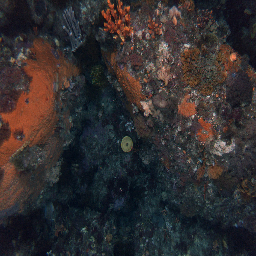

In [35]:
filename = '../data/train/PR_20090326_012036_840_LC16.jpeg'
Image.open(filename).resize((sz, sz))

In [38]:
from fastai.core import *
from fastai.transforms import *
from fastai.dataset import *
import torch

model = torch.load('../model/coralAI_v1.pt')
model = model.eval()

arch = resnet34
sz = 256
_, tfms = tfms_from_model(arch, sz)

image = Variable(torch.Tensor(tfms(open_image(filename))[None]))

# pred = model(image).data.numpy()
# 'dog' if np.argmax(pred,axis=-1)[0] == 1 else 'cat'
log_probs = model.cpu()(image.cpu()).data.numpy()
# log_probs

In [39]:
top = 5
top_pred = log_probs.argsort()[0][::-1][:top]
[learn.data.classes[i] for i in top_pred]

['2', '16', '29', '166', '26']

## Ignore

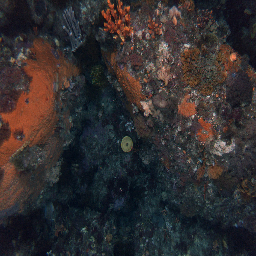

In [10]:
image_path = '../data/train/PR_20090326_012036_840_LC16.jpeg'
# image_path = '../data/test/PR_20081006_235301_635_LC16.jpeg'

trn_tfms, val_tfrms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
im = val_tfrms(open_image(image_path))

Image.open(image_path).resize((sz, sz))

In [11]:
learn.precompute = False
# learn.eval()
log_probs = learn.predict_array(im[None])

In [12]:
preds = np.argmax(log_probs, axis=1)
print(preds)
learn.data.classes[np.argmax(log_probs)]

[58]


'2'

In [13]:
# log_probs
import numpy as np
log_probs[0, np.where( log_probs > .5 )[1]]

print(np.where( log_probs > .5 )[1])
print(log_probs[0, np.where( log_probs > .5 )[1]])
[learn.data.classes[i] for i in np.where( log_probs > .5 )[1]]

[ 40  47  58  83  87 124]
[0.81452 0.58079 0.9763  0.57329 0.77388 0.66962]


['16', '166', '2', '26', '29', '67']

In [14]:
top = 5
top_pred = log_probs.argsort()[0][::-1][:top]
[learn.data.classes[i] for i in top_pred]

['2', '16', '29', '67', '166']